In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# download the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

data_dir = './data/cifar10'

# look inside the dataset directory
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)


['train', 'test']
['dog', 'automobile', 'truck', 'deer', 'frog', 'horse', 'airplane', 'bird', 'cat', 'ship']


In [ ]:
# data transforms (normalization & augmentation)
cifar10_stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_transroms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                              tt.RandomHorizontalFlip(),
                              tt.ToTensor(),
                              tt.Normalize(*cifar10_stats)])
validation_transforms = tt.Compose([tt.ToTensor(), tt.Normalize(*cifar10_stats)])

In [ ]:
# pythorch datasets
train_ds = ImageFolder(data_dir+'/train', train_transroms)
validation_ds = ImageFolder(data_dir+'/test', validation_transforms)

In [ ]:
batch_size = 256
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
train_dl = DataLoader(validation_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images*stds+means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]), ax.set_yticks([])
        denorm_images = denormalize(images, *cifar10_stats)
        ax.imshow(make_grid(denorm_images[:64], 8).permute(1,2,0).clamp(0, 1))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


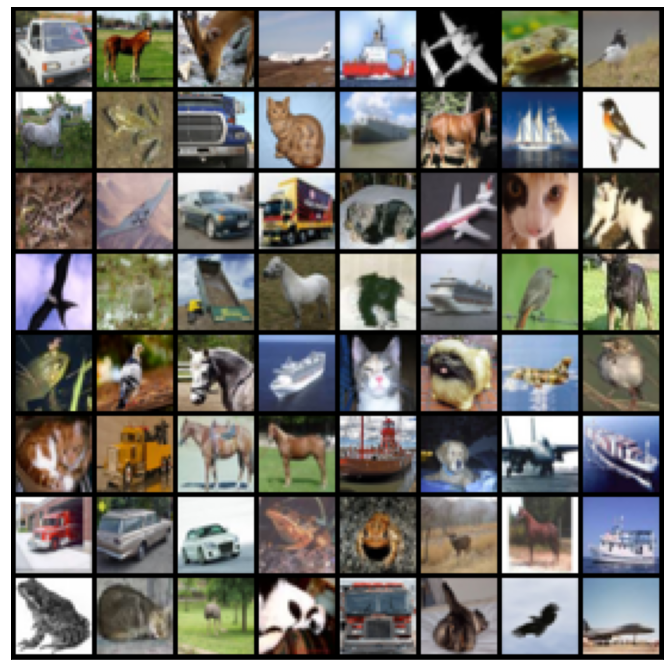

In [ ]:
show_batch(train_dl)

In [ ]:
class Generator(nn.Module):
    def __init__(self, embeddings=None, num_channels=3, channels_noise=100, features_g=64):
        super(Generator, self).__init__()
        self.linear = nn.Linear(200,100)
        self.embeddings = embeddings
        self.net = nn.Sequential(
            # input: noise_dim x 1 x 1
            nn.ConvTranspose2d(channels_noise, features_g*4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(features_g*8),
            nn.ReLU(),
            # out: 256 x 4 x 4

            nn.ConvTranspose2d(features_g*4, features_g*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_g*4),
            nn.ReLU(),
            # out: 128 x 8 x 8

            nn.ConvTranspose2d(features_g*2, features_g*1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_g*2),
            nn.ReLU(),
            # out: 64 x 16 x 16

            nn.ConvTranspose2d(features_g, num_channels, kernel_size=4, stride=2, padding=1, bias=False),
            # out: 3 x 32 x 32
            nn.Tanh()
        )

    def forward(self, x, label_embed):
        label_embed = self.embeddings(label_embed)

        x = x.view(-1,100)
        x = torch.cat([x,label_embed], dim=1)

        x = self.linear(x)
        x = x.unsqueeze(2).unsqueeze(3)

        output = self.net(x)
        return output

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, embeddings=None, num_channels=3, features_d=64):
        super(Discriminator, self).__init__()
        self.embeddings = embeddings

        self.label_to_image = nn.Linear(100,32*32*3)
        self.conv1 = nn.Conv2d(num_channels * 2, num_channels, 1, 1, 0, bias=False)
        self.net = nn.Sequential(

            nn.Conv2d(num_channels, features_d, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d),
            nn.LeakyReLU(0,2),

            nn.Conv2d(features_d, features_d*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d*2),
            nn.LeakyReLU(0,2),

            nn.Conv2d(features_d*2, features_d*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(features_d*4),
            nn.LeakyReLU(0,2),
            
            nn.Conv2d(features_d*4, 1, kernel_size=4, stride=1, padding=1, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )
    
    def forward(self, x, label_embed):
        label_embed = self.embeddings(label_embed)

        label_map = self.label_to_image(label_embed)
        label_map = label_map.view(-1,3,32,32)

        x = torch.cat([x,label_map], dim=1)

        out = self.conv1(x)
        output = self.net(out)

        return output

In [ ]:
from torchvision.utils import save_image
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, label_embed, show=True):
  fake_images = gen(latent_tensors, label_embed)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print('Saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
embeddings = nn.Embedding(10,100)
embeddings.weight.requires_grad = False

netD = Discriminator(embeddings).to(device)
netG = Generator(embeddings).to(device)

netD.train()
netG.train()

channels_noise = 100

criterion = nn.BCELoss()
criterion.to(device)

num_epochs = 100

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def train_discriminator(real_images, opt_d, noise, label_embed):
    opt_d.zero_grad()
    real_preds = netD(real_images, label_embed)
    real_targets = torch.ones(real_images.size(0), 1).to(device)
    real_loss = criterion(real_preds.view(batch_size, -1), real_targets)
    real_score = torch.mean(real_preds).item()

    fake_images = netG(noise, labels_embed)

    fake_targets = torch.zeros(fake_images.size(0), 1).to(device)
    fake_preds = netD(fake_images, label_embed)
    fake_loss = criterion(fake_preds.view(batch_size, -1), fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = (real_loss + fake_loss) / 2
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g, noise):
    opt_g.zero_grad()
    new_label = torch.LongTensor(batch_size, 10).random_(0,10).to(device)
    new_embed = new_label[:,0].view(-1)
    fake_images = netG(noise, new_embed)

    preds = netD(fake_images, new_embed)
    targets = torch.ones(batch_size, 1, device=device)
    loss = criterion(preds.view(batch_size, -1), targets)

    loss.backward()
    opt_g.step()
    return loss.item()

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    #losses&scores
    losses_g, losses_d, real_scores, fake_scores = [], [], [], []
    #create optimizers
    optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
    for epoch in range(epochs):
        for real_images, labels in tqdm(train_dl):
            fixed_noise = torch.randn(batch_size, channels_noise, 1, 1).to(device)
            real_images.to(device)
            label_embed = labels.to(device)
            #train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, optimizerD, fixed_noise, label_embed)
            #train generator
            loss_g = train_generator(optimizerG, fixed_noise)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_score.append(real_score)
        fake_scores.append(fake_score)

        print('Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}'.format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores


In [ ]:
lr = 2e-4
epochs = 100

In [ ]:
history = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RuntimeError: ignored

In [ ]:
real_label = torch.ones([batch_size, 1], dtype=torch.float).to(device)
fake_label = torch.zeros([batch_size ,1], dtype=torch.float).to(device)

losses_g, losses_d, real_scores, fake_scores = [], [], [], []
for epoch in range(num_epochs):
    idx = 0
    for i, (input_sequence, label) in enumerate(train_dl):
        fixed_noise = torch.randn(batch_size, channels_noise, 1, 1, device=device)

        input_sequence = input_sequence.to(device)
        label_embed = label.to(device)
        '''
            Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        '''

        D_real_result = netD(input_sequence, label_embed)
        D_real_loss = criterion(D_real_result.view(batch_size, -1), real_label.reshape)

        G_result = netG(fixed_noise, label_embed)

        D_fake_result = netD(G_result, label_embed)

        D_fake_loss = criterion(D_fake_result.view(batchsize, -1), fake_label)
        real_score = torch.mean(D_real_result).item()
        fake_score = torch.mean(D_fake_result).item()
            # Back propagation
        D_train_loss = (D_real_loss + D_fake_loss) / 2

        netD.zero_grad()
        D_train_loss.backward()
        optimizerD.step()

        '''
                Update G network: maximize log(D(G(z)))
        '''
        new_label = torch.LongTensor(batchsize, 10).random_(0, 10).to(device)
        new_embed = new_label[:, 0].view(-1)

        G_result = netG(fixed_noise, new_embed)

        D_fake_result = netD(G_result, new_embed)
        G_train_loss = criterion(D_fake_result.view(batchsize, -1), real_label)

        losses_g.append(G_train_loss.item())
        losses_d.append(D_train_loss.item())
        real_score.append(real_score)
        fake_scores.append(fake_score)


            # Back propagation
        netD.zero_grad()
        netG.zero_grad()
        G_train_loss.backward()
        optimizerG.step()

        print('Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}'.format(
        epoch+1, num_epochs, G_train_loss.item(), D_train_loss.item(), real_score, fake_score))

        # save generated images
        save_samples(epoch+idx, fixed_noise, new_embed, show=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AttributeError: ignored

In [ ]:
D_real_result = netD(input_sequence, label_)